In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load sample data (replace with your actual data loading)
data = pd.read_csv("Dataset/1000dos_dataset.csv", header=None)
# Assign column names
data.columns = ['Timestamp', 'CAN_ID', 'DLC', 'DATA0', 'DATA1',
                'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']

# Convert Flag column to numerical labels using label encoding
label_encoder = LabelEncoder()
data['Flag'] = label_encoder.fit_transform(data['Flag'])

data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Convert CAN ID and DLC to integer
data["CAN_ID"] = data["CAN_ID"].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
data["DLC"] = data["DLC"].astype(int)


In [75]:
# Convert DATA fields from hexadecimal strings to integers
def hex_to_int(x):
    if isinstance(x, str):
        try:
            return int(x, 16)
        except ValueError:
            return np.nan
    else:
        return x

# Convert DATA fields from hexadecimal strings to integers
for i in range(8):
    data[f"DATA{i}"] = data[f"DATA{i}"].apply(hex_to_int).astype(float)

# Assuming 'Flag' column represents the target variable
X = data.drop('Flag', axis=1)  # Features
y = data['Flag']  # Target variable

In [76]:


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop 'Timestamp' column from input features
X_train = X_train.drop('Timestamp', axis=1)
X_test = X_test.drop('Timestamp', axis=1)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

def SVC_Scan(x_train,y_train,x_test):
    # Initialize SVC with non-linear kernel
    svc_classifier = SVC(kernel='rbf')  # rbf stands for Radial Basis Function (non-linear)

    # Train the classifier
    svc_classifier.fit(x_train, y_train)
    # Predict on the test set
    
    return svc_classifier.predict(x_test)
    

def MLP_Scan(x_train,y_train,x_test):
    # Initialize MLP Classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)  # Example parameters

    # Train the classifier
    mlp_classifier.fit(x_train, y_train)
    # Predict on the test set
    return mlp_classifier.predict(x_test)

def SGD_Scan(x_train,y_train,x_test):
   # Initialize SGD Classifier
    sgd_classifier = SGDClassifier()

    # Train the classifier
    sgd_classifier.fit(X_train_imputed, y_train)

    # Predict on the test set
    return sgd_classifier.predict(X_test_imputed)

def Linear_regression_Scan(x_train,y_train,x_test):
    # Initialize Linear Regression model
    linear_reg_classifier = LinearRegression()

    # Train the classifier
    linear_reg_classifier.fit(x_train, y_train)

    # Predict probabilities on the test set
    y_pred_prob = linear_reg_classifier.predict(x_test)

    # Convert probabilities to binary predictions using a threshold
    threshold = 0.5
    y_pred_binary = (y_pred_prob >= threshold).astype(int)
    return y_pred_binary

# Calculate total number of samples in the test set
total_samples = len(y_test)
#Run SVC ML
svc_y_predict= SVC_Scan(X_train_imputed,y_train,X_test_imputed);
svc_precision, svc_recall, svc_f1_score, _ = precision_recall_fscore_support(y_test, svc_y_predict, average='weighted', zero_division=1)
# Calculate support values
svc_support = pd.Series(y_test).value_counts()

# Convert support values to percentages
support_percentage = (svc_support / total_samples) * 100
print("SVC Precision:", svc_precision*100)
print("SVC Recall:", svc_recall*100)
print("SVC F1 Score:", svc_f1_score*100)
print("SVC Support:", support_percentage)
# print(svc_support)



#Run MLP ML
mlp_y_predict=MLP_Scan(X_train_imputed,y_train,X_test_imputed);
mlp_precision, mlp_recall, mlp_f1_score, _ = precision_recall_fscore_support(y_test, mlp_y_predict, average='weighted', zero_division=1)
mlp_support = pd.Series(y_test).value_counts()

print("MLP Precision:", mlp_precision*100)
print("MLP Recall:", mlp_recall*100)
print("MLP F1 Score:", mlp_f1_score*100)

# print("MLP Support", mlp_support)

#Run SGD ML
sgd_y_predict=SGD_Scan(X_train_imputed,y_train,X_test_imputed);
sgd_precision, sgd_recall, sgd_f1_score, _ = precision_recall_fscore_support(y_test, sgd_y_predict, average='weighted', zero_division=1)
sgd_support = pd.Series(y_test).value_counts()

print("SGD Precision:", sgd_precision*100)
print("SGD Recall:", sgd_recall*100)
print("SGD F1 Score:", sgd_f1_score*100)

#Run LRG ML
lr_y_predict=Linear_regression_Scan(X_train_imputed,y_train,X_test_imputed);
lr_precision, lr_recall, lr_f1_score, _ = precision_recall_fscore_support(y_test, lr_y_predict, average='weighted', zero_division=1)
print("LR Precision:", lr_precision*100)
print("LR Recall:", lr_recall*100)
print("LR F1 Score:", lr_f1_score*100)


SVC Precision: 99.21584038813509
SVC Recall: 99.19416730621641
SVC F1 Score: 99.19733710819794
SVC Support: Flag
0    70.222563
1    29.048350
2     0.729087
Name: count, dtype: float64
MLP Precision: 100.0
MLP Recall: 100.0
MLP F1 Score: 100.0
SGD Precision: 99.88700192218829
SGD Recall: 99.8848810437452
SGD F1 Score: 99.88537641048416
LR Precision: 97.54125211933024
LR Recall: 97.31389102072141
LR F1 Score: 96.99487214292152


In [77]:

# Calculate precision, recall, and F2 score
# precision = precision_score(y_test, y_pred, average='micro')
# recall = recall_score(y_test, y_pred, average='micro')
# f2_score = fbeta_score(y_test, y_pred, beta=2, average='micro')
# Convert class labels to strings
classes = [str(cls) for cls in label_encoder.classes_]




In [78]:


# Define the models and their corresponding metrics
models = ['SVC', 'MLP','SGD','LRG']
precision = [svc_precision*100, mlp_precision*100,sgd_precision*100, lr_precision*100]
recall = [svc_recall*100, mlp_recall*100,sgd_recall*100,lr_recall*100]
f1_score = [svc_f1_score*100, mlp_f1_score*100,sgd_f1_score*100,lr_f1_score*100]
# support = [0.985408232, 1, 0.95, 0.92]

# Define the metrics to plot
metrics = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1_score]

values

[[99.21584038813509, 100.0, 99.88700192218829, 97.54125211933024],
 [99.19416730621641, 100.0, 99.8848810437452, 97.31389102072141],
 [99.19733710819794, 100.0, 99.88537641048416, 96.99487214292152]]

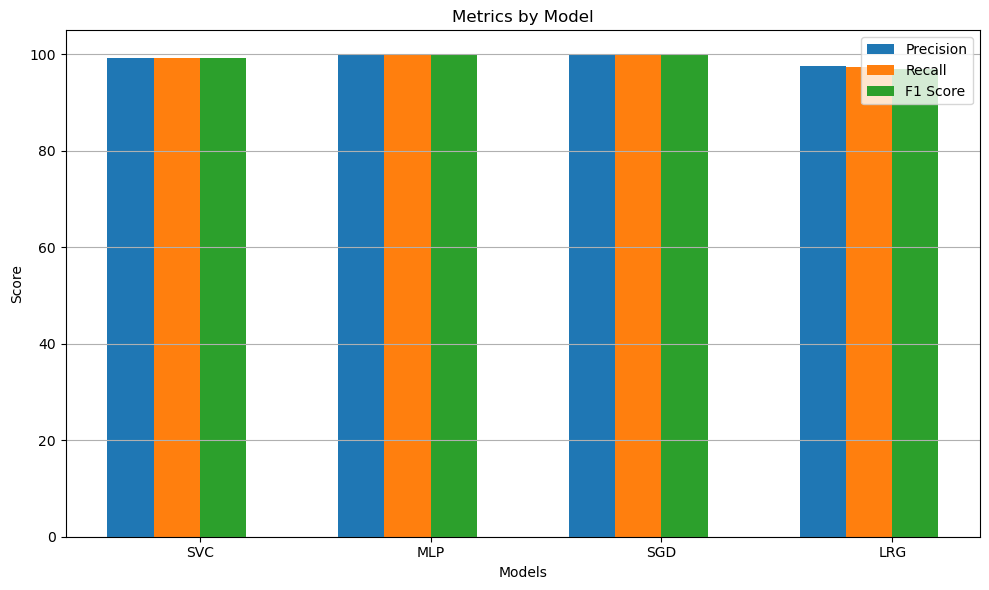

In [79]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot bars for each metric and model
bar_width = 0.2
index = np.arange(len(models))

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, values[i], bar_width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Metrics by Model')
plt.xticks(index + bar_width * 1.5, models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


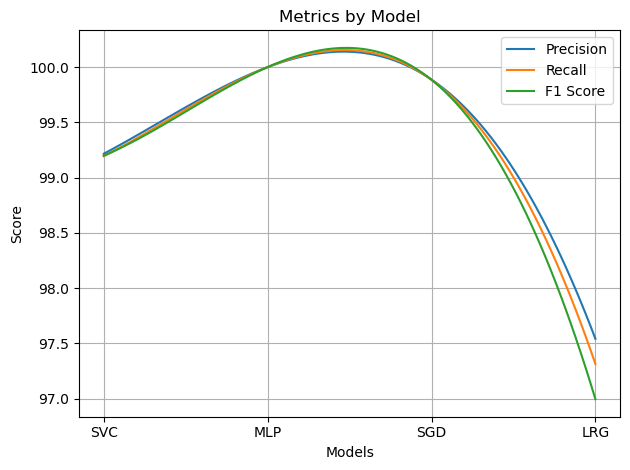

In [80]:
# Plot curved lines for each metric and model
for i, metric in enumerate(metrics):
    f = interp1d(np.arange(len(models)), values[i], kind='cubic')
    x_new = np.linspace(0, len(models) - 1, 100)
    y_new = f(x_new)
    plt.plot(x_new, y_new, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Metrics by Model')
plt.xticks(np.arange(len(models)), models)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()